# Import Headers

Use conda_tensorflow2_p36 Sagemaker kernel

In [10]:
# Pandas, SKLEARN headers
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
tqdm.pandas()
pd.set_option('max_colwidth',0)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import joblib

#NLTK headers
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

# Keras headers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, LSTM
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
#from pandas_profiling import ProfileReport

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load DataSet and rename columns

In [2]:
url = "https://raw.githubusercontent.com/Cameron-Watts/PDS_Piece/main/data/raw/twitter_training.csv"
df = pd.read_csv(url, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])
# rename columns
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_text']

#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

#Convert the "Sentiment" column into indexes
df["sentiment_index"] = names_to_ids(df["sentiment"])

# Twitter Sentiment Analysis Dataset - Overview
# This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

# Look at dataset

In [3]:
df.head(5)

,tweet_id,entity,sentiment,tweet_text,sentiment_index
0,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3
1,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,",3
2,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,",3
3,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,",3
4,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,",3


In [4]:
df.sentiment.value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         74682 non-null  int64 
 1   entity           74682 non-null  object
 2   sentiment        74682 non-null  object
 3   tweet_text       73996 non-null  object
 4   sentiment_index  74682 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


# Filter out rows where tweet_text is NULL

In [6]:
# fiter data where tweet is present
df = df[df.tweet_text.isnull()==False]
df['tweet_text'] = df['tweet_text'].astype(str)

# Stratified Sampling - For this session purposes lets restrict to 5000 records for each class

In [7]:
dfs_list = []
for unique_sentiment in np.unique(df.sentiment):
    df_sentiment = df[df.sentiment == unique_sentiment].sample(n=5000, random_state = 42)
    dfs_list.append(df_sentiment)
df = pd.concat(dfs_list)
df = df.sample(frac=1, random_state = 42)
df = df.reset_index(drop = True)

In [8]:
df.sentiment.value_counts()

Irrelevant    5000
Positive      5000
Negative      5000
Neutral       5000
Name: sentiment, dtype: int64

# We might want to look at what is present in the tweets. So a wordcloud can be helpful

In [9]:
!pip install wordcloud

In [10]:
import os
from wordcloud import WordCloud
def word_cloud(tweets):
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array    
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                           background_color="black", max_words=2000, 
                           contour_width=1, contour_color="steelblue", 
                           colormap="nipy_spectral").generate(tweets)

    #Now we plot the figure
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()   


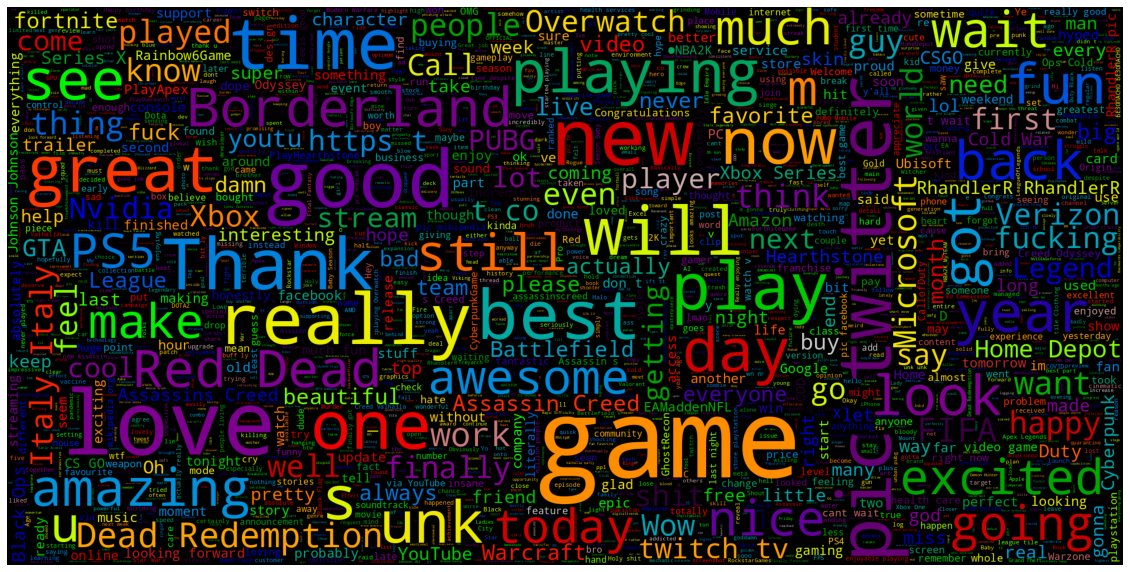

CPU times: user 31 s, sys: 1.37 s, total: 32.4 s
Wall time: 32.4 s


In [11]:
%%time
# Positive tweets word cloud
word_cloud((df[df.sentiment=='Positive'].tweet_text).str.cat(sep=' ')) 

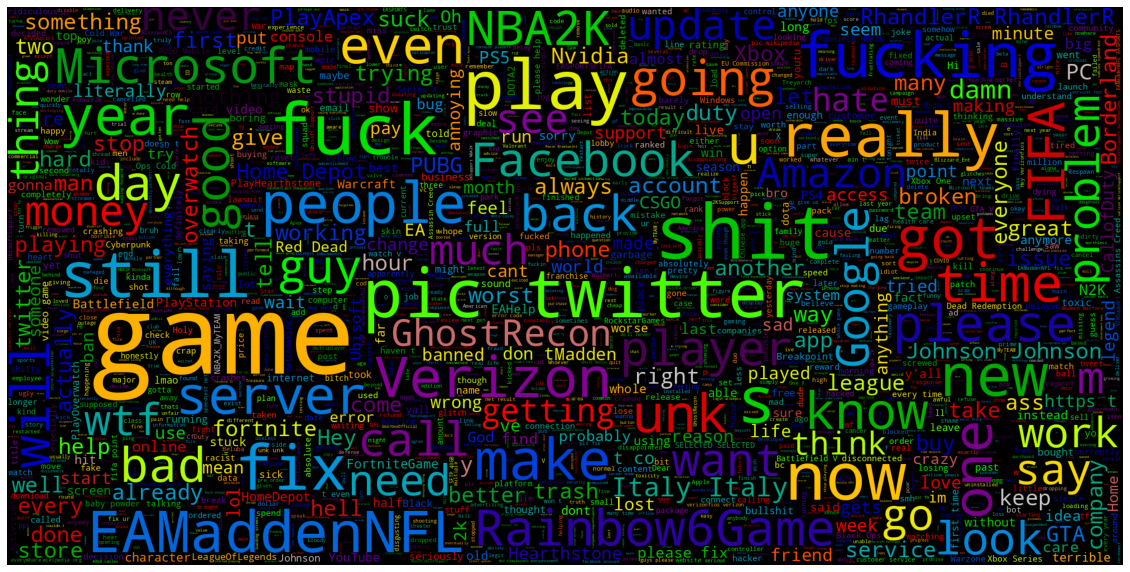

CPU times: user 30.5 s, sys: 1.28 s, total: 31.8 s
Wall time: 31.8 s


In [12]:
%%time
# Negative tweets word cloud
word_cloud((df[df.sentiment=='Negative'].tweet_text).str.cat(sep=' ')) 

# Modelling 
# Two approaches

# Classic BOW model
# Keras Embedding Layer + Fully Connected model

# Prepare dataset for modelling

In [13]:
!pip install nltk

In [14]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
df.head()

,tweet_id,entity,sentiment,tweet_text,sentiment_index
0,6960,johnson&johnson,Neutral,Johnson Son Son to continue selling talc baby food in U.S. and Canada j.mp/3e1YtDV (Reuters) report],0
1,10246,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,Nade gets the win,1
2,5680,HomeDepot,Negative,fuck Home Home Depot,2
3,290,Amazon,Irrelevant,"Bolsonaro is as evil, racist, and incompetent a leader as Donald Trump. He's selfish, ignorant, and racist. Apart from destroying the beautiful Amazon forest ecosystem, he despises the Afro-Brazilians! facebook.com/12326927434830…",1
4,1431,Battlefield,Neutral,Flank out with 9 bomb kills.. store. playstation. com /,0


### Save dataframe for later

In [16]:
df.to_csv('tweets.csv')

In [17]:
%%time
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet_text):
    tweet_text = re.sub('[^a-zA-Z]', ' ', tweet_text)
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.split()
    tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if not word in set(stopwords)]
    tweet_text = ' '.join(tweet_text)
    return tweet_text

df['tweet_text_preprocessed'] = df['tweet_text'].progress_apply(preprocess_tweet)
df = df[df.tweet_text_preprocessed.apply(lambda text: len(text.split())>1)]
#df['tweet_tokenized'] = df['tweet_tokenized'].progress_apply(lemmatize)

100%|██████████| 20000/20000 [00:04<00:00, 4773.81it/s]

CPU times: user 4.1 s, sys: 124 ms, total: 4.23 s
Wall time: 4.22 s


In [18]:
df.head()

,tweet_id,entity,sentiment,tweet_text,sentiment_index,tweet_text_preprocessed
0,6960,johnson&johnson,Neutral,Johnson Son Son to continue selling talc baby food in U.S. and Canada j.mp/3e1YtDV (Reuters) report],0,johnson son son continue selling talc baby food u canada j mp e ytdv reuters report
1,10246,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,Nade gets the win,1,nade get win
2,5680,HomeDepot,Negative,fuck Home Home Depot,2,fuck home home depot
3,290,Amazon,Irrelevant,"Bolsonaro is as evil, racist, and incompetent a leader as Donald Trump. He's selfish, ignorant, and racist. Apart from destroying the beautiful Amazon forest ecosystem, he despises the Afro-Brazilians! facebook.com/12326927434830…",1,bolsonaro evil racist incompetent leader donald trump selfish ignorant racist apart destroying beautiful amazon forest ecosystem despises afro brazilian facebook com
4,1431,Battlefield,Neutral,Flank out with 9 bomb kills.. store. playstation. com /,0,flank bomb kill store playstation com


### Save processed tweets for comparison later

In [19]:
df.to_csv('tweets_test.csv', index=False)

### Write out processing script for the ScriptProcessor (SKLearn)

In [20]:
%%writefile process_tweets.py
import os
import pandas as pd
import re
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
install('nltk')
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')


def preprocess_tweet(tweet_text):
    tweet_text = re.sub('[^a-zA-Z]', ' ', tweet_text)
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.split()
    tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if not word in set(stopwords)]
    tweet_text = ' '.join(tweet_text)
    return tweet_text


def main(input_file, output_file):
    df = pd.read_csv(input_file)
    #df['tweet_text_preprocessed'] = df['tweet_text'].progress_apply(preprocess_tweet)
    df['tweet_text_preprocessed'] = df.apply(lambda x: preprocess_tweet(x['tweet_text']), axis=1)
    df = df[df.tweet_text_preprocessed.apply(lambda text: len(text.split())>1)]
    df.to_csv(output_file, index=False)

    
if __name__ == "__main__":

    input_file = os.path.join('/opt/ml/processing/input', 'tweets.csv')
    output_file = os.path.join('/opt/ml/processing/output', 'tweets_processed.csv')
    #input_file = os.path.join('.', 'tweets.csv')
    #output_file = os.path.join('.', 'tweets_processed.csv')
    
    main(input_file, output_file)

Overwriting process_tweets.py


In [21]:
#!python process_tweets.py

### Initialize Sagemaker SKLearnProcessor

In [22]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

region = boto3.session.Session().region_name

role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.xlarge',
                                     instance_count=1)

### TODO: Create bucket

In [92]:
!aws s3 cp tweets.csv s3://dsml-chrisi-bucket/tweets/tweets.csv

upload: ./tweets.csv to s3://dsml-chrisi-bucket/tweets/tweets.csv


### Run Processor

In [93]:
%%time
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code='process_tweets.py',
    inputs=[
        ProcessingInput(
            source='s3://dsml-chrisi-bucket/tweets/tweets.csv',
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='tweet_output',
            source='/opt/ml/processing/output',
            destination='s3://dsml-chrisi-bucket/tweets'
        )
    ]
)


Job Name:  sagemaker-scikit-learn-2022-03-24-03-24-02-963
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://dsml-chrisi-bucket/tweets/tweets.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-995383923238/sagemaker-scikit-learn-2022-03-24-03-24-02-963/input/code/process_tweets.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'tweet_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://dsml-chrisi-bucket/tweets', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................Collecting nltk
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/exte

### View output

In [95]:
!aws s3 ls s3://dsml-chrisi-bucket/tweets/

2022-03-24 03:24:01    2924853 tweets.csv
2022-03-24 03:28:15    4303776 tweets_processed.csv


In [29]:
df2 = pd.read_csv('s3://dsml-chrisi-bucket/tweets/tweets_processed.csv') #, index_col=[0])
df2[['tweet_text','tweet_text_preprocessed', 'sentiment']].head(30)

,tweet_text,tweet_text_preprocessed,sentiment
0,Johnson Son Son to continue selling talc baby food in U.S. and Canada j.mp/3e1YtDV (Reuters) report],johnson son son continue selling talc baby food u canada j mp e ytdv reuters report,Neutral
1,Nade gets the win,nade get win,Irrelevant
2,fuck Home Home Depot,fuck home home depot,Negative
3,"Bolsonaro is as evil, racist, and incompetent a leader as Donald Trump. He's selfish, ignorant, and racist. Apart from destroying the beautiful Amazon forest ecosystem, he despises the Afro-Brazilians! facebook.com/12326927434830…",bolsonaro evil racist incompetent leader donald trump selfish ignorant racist apart destroying beautiful amazon forest ecosystem despises afro brazilian facebook com,Irrelevant
4,Flank out with 9 bomb kills.. store. playstation. com /,flank bomb kill store playstation com,Neutral
5,5 Broken bottle kills in a row. Part II. . . .,broken bottle kill row part ii,Neutral
6,"Was just at @HomeDepot & while waiting in line to pay, the guy in front of me takes off his . & starts to pay the cashier without a . . Dude gets pissed & yells at the cashier to stop telling him what to do. WTF!?",homedepot waiting line pay guy front take start pay cashier without dude get pissed yell cashier stop telling wtf,Neutral
7,"It's Toga's birthday yyyyyyayaya, the way I love this liddol bean so much, TT my username on pubg is Toga himiko (sounds kind of crisp now) I love it sm I can't... I could get bored of a lot of things, but bnha isn't it. pic.twitter.com / 0EspuuuKyHL",toga birthday yyyyyyayaya way love liddol bean much tt username pubg toga himiko sound kind crisp love sm could get bored lot thing bnha pic twitter com espuuukyhl,Irrelevant
8,I wake up and read with curiosity the changes of the priest. Thank you for respecting the community!,wake read curiosity change priest thank respecting community,Positive
9,@Rainbow6Game im finding an error code saying sorry the u play servers are down and ive like anything you can ask of. whats going on?,rainbow game im finding error code saying sorry u play server ive like anything ask whats going,Negative


# Take a look at pre-processed text

In [30]:
df[['tweet_text','tweet_text_preprocessed', 'sentiment']].head(30)

,tweet_text,tweet_text_preprocessed,sentiment
0,Johnson Son Son to continue selling talc baby food in U.S. and Canada j.mp/3e1YtDV (Reuters) report],johnson son son continue selling talc baby food u canada j mp e ytdv reuters report,Neutral
1,Nade gets the win,nade get win,Irrelevant
2,fuck Home Home Depot,fuck home home depot,Negative
3,"Bolsonaro is as evil, racist, and incompetent a leader as Donald Trump. He's selfish, ignorant, and racist. Apart from destroying the beautiful Amazon forest ecosystem, he despises the Afro-Brazilians! facebook.com/12326927434830…",bolsonaro evil racist incompetent leader donald trump selfish ignorant racist apart destroying beautiful amazon forest ecosystem despises afro brazilian facebook com,Irrelevant
4,Flank out with 9 bomb kills.. store. playstation. com /,flank bomb kill store playstation com,Neutral
5,5 Broken bottle kills in a row. Part II. . . .,broken bottle kill row part ii,Neutral
6,"Was just at @HomeDepot & while waiting in line to pay, the guy in front of me takes off his . & starts to pay the cashier without a . . Dude gets pissed & yells at the cashier to stop telling him what to do. WTF!?",homedepot waiting line pay guy front take start pay cashier without dude get pissed yell cashier stop telling wtf,Neutral
7,"It's Toga's birthday yyyyyyayaya, the way I love this liddol bean so much, TT my username on pubg is Toga himiko (sounds kind of crisp now) I love it sm I can't... I could get bored of a lot of things, but bnha isn't it. pic.twitter.com / 0EspuuuKyHL",toga birthday yyyyyyayaya way love liddol bean much tt username pubg toga himiko sound kind crisp love sm could get bored lot thing bnha pic twitter com espuuukyhl,Irrelevant
8,I wake up and read with curiosity the changes of the priest. Thank you for respecting the community!,wake read curiosity change priest thank respecting community,Positive
9,@Rainbow6Game im finding an error code saying sorry the u play servers are down and ive like anything you can ask of. whats going on?,rainbow game im finding error code saying sorry u play server ive like anything ask whats going,Negative


In [7]:
import pandas as pd
df = pd.read_csv('tweets_processed.csv')

# Take a look at the number of rows

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18753 entries, 0 to 18752
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               18753 non-null  int64 
 1   tweet_id                 18753 non-null  int64 
 2   entity                   18753 non-null  object
 3   sentiment                18753 non-null  object
 4   tweet_text               18753 non-null  object
 5   sentiment_index          18753 non-null  int64 
 6   tweet_text_preprocessed  18753 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.0+ MB


# Split into train and test

In [11]:
train_df, test_df = train_test_split(df,test_size = 0.05, random_state =42)
X_train = train_df['tweet_text_preprocessed']
y_train = train_df['sentiment']

X_test = test_df['tweet_text_preprocessed']
y_test = test_df['sentiment']

In [14]:
X_train

3265     love also piss fantasy conference canceled mgiraldi                                                                    
12614    hey uhh siege good game buuut thaat good go top th player world                                                        
5516     finished nd live watch keep long process pubg highlight list last week like subscribe thanks youtube com watch v megqln
7341     shout hello eamaddennfl making top rated free agent agent well                                                         
2874     far good                                                                                                               
           ...                                                                                                                  
11284    new video game celebrate every vr                                                                                      
11964    know something wrong even nvidia support help solve microstuttering problem love pc     

# Use TF IDF Vectorizer 

In [68]:
# TF-IDF feature matrix
max_number_of_words = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=max_number_of_words, lowercase =True, stop_words='english', token_pattern=r'\w{2,}')
tfidf_vectorizer.fit(X_train)
print('No. of feature_words: ', len(tfidf_vectorizer.get_feature_names()))

No. of feature_words:  1000


In [69]:
X_train = tfidf_vectorizer.transform(X_train)
X_test  = tfidf_vectorizer.transform(X_test)

In [70]:
%%time
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

CPU times: user 19.3 s, sys: 36.2 ms, total: 19.3 s
Wall time: 19.3 s


RandomForestClassifier(random_state=42)

In [41]:
# export model
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(rf_clf, "random_forest.joblib")

['random_forest.joblib']

### Write out training script for Estimator

In [21]:
%%writefile train_model.py

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

import joblib


def train(input_file, output_folder):
    df = pd.read_csv(input_file)
    #df = df[['tweet_text','tweet_text_preprocessed', 'sentiment']]
    print(df.head())
    
    train_df, test_df = train_test_split(df,test_size = 0.05, random_state =42)
    X_train = train_df['tweet_text_preprocessed']
    y_train = train_df['sentiment']
    

    X_test = test_df['tweet_text_preprocessed']
    y_test = test_df['sentiment']
    
    # TF-IDF feature matrix
    max_number_of_words = 1000
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=max_number_of_words, lowercase =True, stop_words='english', token_pattern=r'\w{2,}')
    tfidf_vectorizer.fit(X_train)
    print('No. of feature_words: ', len(tfidf_vectorizer.get_feature_names()))

    X_train = tfidf_vectorizer.transform(X_train)
    X_test  = tfidf_vectorizer.transform(X_test)
    
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)

    
    # export model
    joblib.dump(tfidf_vectorizer, os.path.join(output_folder, "tfidf_vectorizer.joblib"))
    joblib.dump(rf_clf, os.path.join(output_folder, "random_forest.joblib"))
    
    # Process here
    #df.to_csv(output_file, index=False)

    
if __name__ == "__main__":

    #input_file = os.path.join('/opt/ml/processing/input', 'tweets_processed.csv')
    #input_file = os.path.join('.', 'tweets.csv')
    #output_file = os.path.join('.', 'tweets_processed.csv')
    
    input_file = os.environ.get('SM_CHANNEL_TRAIN') + '/tweets_processed.csv'
    output_folder = os.environ.get('SM_MODEL_DIR') #os.path.join('/opt/ml/processing/output', 'tweets_processed.csv')
    
    print('Input', input_file)
    print('Output', output_folder)
    
    #input_file = os.path.join('.', 'tweets_processed.csv')
    #output_folder = '.'
    
    train(input_file, output_folder)

Overwriting train_model.py


In [19]:
#pd.read_csv('tweets_processed.csv')

In [20]:
#!python train_model.py

   Unnamed: 0  ...                            tweet_text_preprocessed
0           0  ...  johnson son son continue selling talc baby foo...
1           1  ...                                       nade get win
2           2  ...                               fuck home home depot
3           3  ...  bolsonaro evil racist incompetent leader donal...
4           4  ...              flank bomb kill store playstation com

[5 rows x 7 columns]
No. of feature_words:  1000


In [22]:
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [23]:
from sagemaker.tensorflow import TensorFlow


estimator = TensorFlow(
                 entry_point='train_model.py',
                 #dependencies=dependencies,
                 instance_type='ml.p3.2xlarge',
                 #instance_type='ml.p3.8xlarge',
                 instance_count=1,
                 source_dir='.',
                 role=role,
                 framework_version='2.3.2', #<--- Changing from 2.2 to 2.3.2 fixed OOM! Refer to "List of containers" ^
                 py_version='py37',
                 #script_mode=True,
                 output_path='s3://dsml-chrisi-bucket/tweets',
                 hyperparameters={
                     #'embedding': True,
                     #'modelstart': 1,
                     #'batch-size': 64, <--- throws an unrecognized arg error
                     #'modelfinish': 5
                 },
                 #image_uri=?????
                 #distribution={'parameter_server': {'enabled': True}},
                 #instance_type='local', #'ml.p3.2xlarge', # # #Local example - https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_using_shell_commands/tensorflow_script_mode_using_shell_commands.ipynb          
)

In [24]:
%%time
estimator.fit({
    'train': 's3://dsml-chrisi-bucket/tweets/',
}, job_name='tweets-chris03')

2022-03-28 19:10:30 Starting - Starting the training job...
2022-03-28 19:10:56 Starting - Preparing the instances for trainingProfilerReport-1648494630: InProgress
.........
2022-03-28 19:12:22 Downloading - Downloading input data
2022-03-28 19:12:22 Training - Downloading the training image.................2022-03-28 19:15:07.077442: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-28 19:15:07.081112: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-03-28 19:15:07.238031: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2022-03-28 19:15:07.313246: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-28 19:15:10,172 sagemaker-training-toolkit INFO     Imported fr

In [27]:
!aws s3 ls s3://dsml-chrisi-bucket/tweets/tweets-chris03/output/

2022-03-28 19:15:48   18115060 model.tar.gz


In [28]:
!aws s3 cp s3://dsml-chrisi-bucket/tweets/tweets-chris03/output/model.tar.gz output/model.tar.gz

download: s3://dsml-chrisi-bucket/tweets/tweets-chris03/output/model.tar.gz to output/model.tar.gz


In [31]:
!tar -xvf output/model.tar.gz

random_forest.joblib
tfidf_vectorizer.joblib


In [44]:
predictions = rf_clf.predict(X_test)

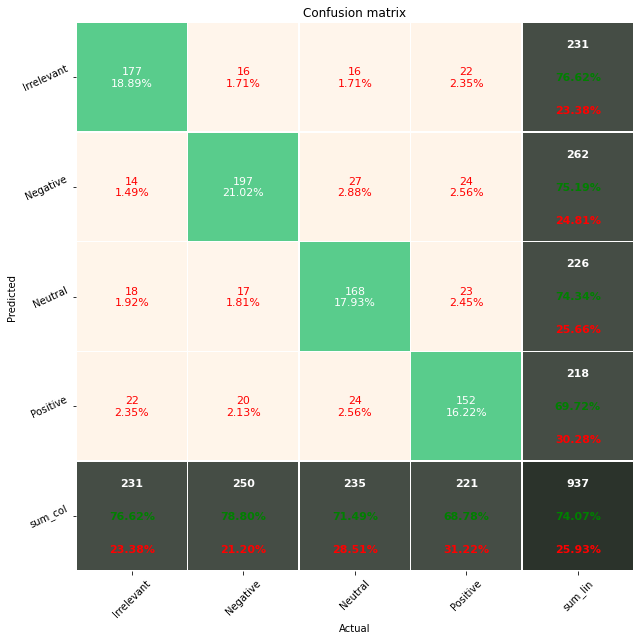

In [45]:
from pretty_confusion_matrix import *
pp_matrix_from_data(y_test, predictions, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

In [67]:
# predict
# load
tfidf_vectorizer = joblib.load("tfidf_vectorizer.joblib")
rf_clf = joblib.load("random_forest.joblib")
negative_tweet_text = 'i had an very sick bad service'
positive_tweet_text = 'i had an excellent service'
def predict(tweet_texts, tfidf_vectorizer):
    processed_texts = []
    for tweet_text in tweet_texts:
        tweet_text = re.sub('[^a-zA-Z]', ' ', tweet_text)
        tweet_text = tweet_text.lower()
        tweet_text = tweet_text.split()
        tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if not word in set(stopwords)]
        tweet_text = ' '.join(tweet_text)
        processed_texts.append(tweet_text)
    tweet_texts_tfidf = tfidf_vectorizer.transform(processed_texts)
    predictions = rf_clf.predict(tweet_texts_tfidf)
    return predictions
predict([negative_tweet_text, positive_tweet_text ], tfidf_vectorizer)

array(['Negative', 'Positive'], dtype=object)

In [68]:
# TFIDF Keras based model
model = Sequential()
model.add(Dense(128,input_dim=max_number_of_words,activation='relu'))
model.add(Dense(64,input_dim=max_number_of_words,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, train_df['sentiment_index'], validation_data=(X_test, test_df['sentiment_index']),
          epochs=30, batch_size=128, verbose=2, callbacks=[es_callback])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 17799 samples, validate on 937 samples
Epoch 1/30
 - 1s - loss: 1.2769 - accuracy: 0.4152 - val_loss: 1.0920 - val_accuracy: 0.5144
Epoch 2/30
 - 0s - loss: 1.0212 - accuracy: 0.5858 - val_loss: 1.0204 - val_accuracy: 0.5571
Epoch 3/30
 - 0s - loss: 0.9013 - accuracy: 0.6431 - val_loss: 0.9966 - val_accuracy: 0.5870
Epoch 4/30
 - 1s - loss: 0.8071 - accuracy: 0.6956 - val_loss: 0.9559 - val_accuracy: 0.6094
Epoch 5/30
 - 0s - loss: 0.6930 - accuracy: 0.7419 - val_loss: 0.9118 - val_accuracy: 0.6564
Epoch 6/30
 - 0s - loss: 0.5701 - accuracy: 0.7990 - val_loss: 0.8752 - val_accuracy: 0.6574
Epoch 7/30
 - 0s - loss: 0.4497 - accuracy: 0.8439 - val_loss: 0.8501 - val_accuracy: 0.7044
Epoch 8/30
 - 0s - loss: 0.3515 - accuracy: 0.8785 - val_loss: 0.8870 - val_accuracy: 0.7065
Epoch 9/30
 - 1s - loss: 0.2792 - accuracy: 0.9070 - val_loss: 0.9116 - val_accuracy: 0.7129
Epoch 10/30
 - 0s - loss: 0.2351 

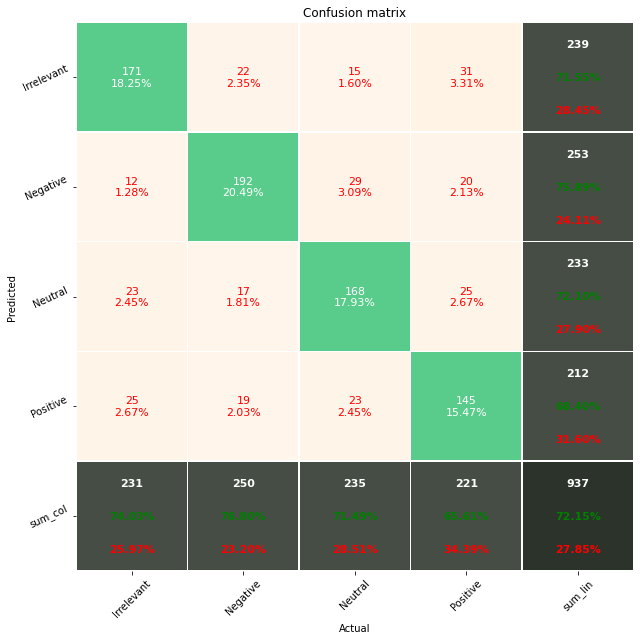

In [69]:
#Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
pp_matrix_from_data(test_df['sentiment'], y_pred_labels, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])
#pp_matrix_from_data(y_test, predictions, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

# TRY IT OUT - Keras tokenization word embedding model

In [ ]:
#Tokenisation

#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(train_df["tweet_tokenized"])

##Train
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_sequences(list(train_df["tweet_tokenized"]))
tweet_tokens = pad_sequences(tweet_tokens, truncating = 'post', padding='post', maxlen=100)

##Test
#Tokenise our column of edited Tweet content
tweet_tokens_test = tokeniser.texts_to_matrix(list(test_df["tweet_tokenized"]))
tweet_tokens_test = pad_sequences(tweet_tokens_test, truncating = 'post', padding='post', maxlen=100)

# Keras text based models

In [ ]:
seed = 7
np.random.seed(seed)

model = Sequential()
#model.add(Embedding(10000,16,input_length=100))
#model.add(Flatten())
model.add(Dense(128,input_dim=shape,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
h = model.fit(
     tweet_tokens, train_df['sentiment_index'],
     validation_data=(tweet_tokens_test, test_df['sentiment_index']),
     epochs=15
)

In [ ]:
#Generate predictions
y_pred = np.argmax(model.predict(tweet_tokens_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
#y_test_labels = ids_to_names(y_test)

from pretty_confusion_matrix import *
pp_matrix_from_data(test_df['sentiment'], y_pred_labels, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

In [ ]:
seed = 7
np.random.seed(seed)

model = Sequential()
model.add(Embedding(10000,16,input_length=100))
model.add(LSTM(20, return_sequences=True))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(4, activation='softmax'))
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
h = model.fit(
     tweet_tokens, train_df['sentiment_index'],
     validation_data=(tweet_tokens_test, test_df['sentiment_index']),
     epochs=15
)

In [ ]:
#Generate predictions
y_pred = np.argmax(model.predict(tweet_tokens_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
#y_test_labels = ids_to_names(y_test)

from pretty_confusion_matrix import *
pp_matrix_from_data(test_df['sentiment'], y_pred_labels, columns = ['Irrelevant','Negative', 'Neutral', 'Positive'])

# TODO : Train model on full dataset and see if you get better performance
# Re